**GAMENet Reproduction Proposal for CS598 DL4H Spring 2023**

**Nile Grice(ngrice2) & Praveen Bhushan (bhushan6)**

**Group ID: 167, Paper ID:173**




**1. Overview**

Graph Augmented Memory Networks (GAMENet)
(Shang et al., 2019) aim is to make medication recommendations that do not lead to adverse drugdrug interactions (DDI). To avoid making drug recommendations that lead to DDI, GAMENet adds a graph convolutional
network built from a combination DDI knowledge as well as electronic health record (EHR) data.

In [ ]:
!pip install dill dnc scikit-learn numpy pandas

**2. GAMENet Model**

GAMENet uses both longitudinal patient EHR data and drug knowledge base on DDIs as inputs.

The model can be broken into the following components: 
1. Dual-RNN Patient Representation
2. Graph Augmented Memory Module
3. Memory Output
4. Combined Loss

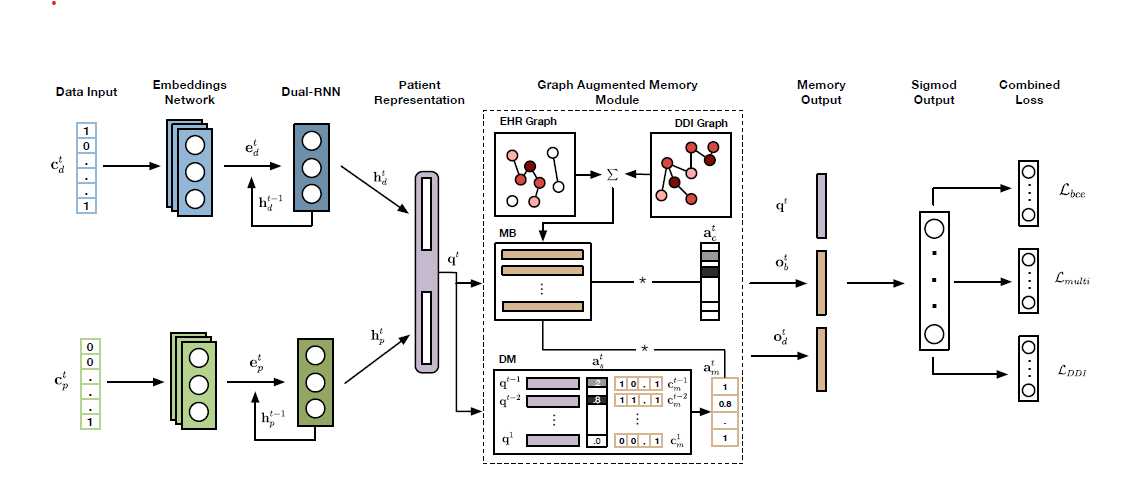

Figure 1: GAMENet

In [ ]:
import torch
import argparse
import numpy as np
import dill
import time
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import os
import torch.nn.functional as F
from collections import defaultdict

#from models import GAMENet
from util import llprint, multi_label_metric, ddi_rate_score, get_n_params

torch.manual_seed(1203)
np.random.seed(1203)

model_name = 'GAMENet'
resume_name = ''
ddi = True #train with ddi graph

**3. Data Preprocessing**

DIAGNOSES_ICD.csv, PRESCRIPTIONS.csv & PROCEDURES_ICD.csv are downloaded from MIMIC and DDI data from TwoSIDES dataset. Data is preprocessed and following files are generated:

* records_final.pkl: Input data with four dimension (patient_idx, visit_idx, medical modal, medical id). 'medical model' is made up of diagnosis, procedure and drug
* voc_final.pkl: Vocabulary list to transform medical word to corresponding idx
* ddi_A_final.pkl & ehr_adj_final.pkl: drug-drug adjacency matrix
* drug-atc.csv, ndc2atc_level4.csv, ndc2rxnorm_mapping.txt: mapping files for drug code transformation

In [ ]:
if not os.path.exists(os.path.join("saved", model_name)):
  os.makedirs(os.path.join("saved", model_name))

data_path = '../data/records_final.pkl'
voc_path = '../data/voc_final.pkl'

ehr_adj_path = '../data/ehr_adj_final.pkl'
ddi_adj_path = '../data/ddi_A_final.pkl'
device = torch.device('cuda:0')

ehr_adj = dill.load(open(ehr_adj_path, 'rb'))
ddi_adj = dill.load(open(ddi_adj_path, 'rb'))
data = dill.load(open(data_path, 'rb'))
voc = dill.load(open(voc_path, 'rb'))
diag_voc, pro_voc, med_voc = voc['diag_voc'], voc['pro_voc'], voc['med_voc']

split_point = int(len(data) * 2 / 3)
data_train = data[:split_point]
eval_len = int(len(data[split_point:]) / 2)
data_test = data[split_point:split_point + eval_len]
data_eval = data[split_point+eval_len:]
voc_size = (len(diag_voc.idx2word), len(pro_voc.idx2word), len(med_voc.idx2word))


**3.1 Data Statistics** 

In [ ]:
import pandas as pd
def statistics(data):
    print(f'{"#patients": <20}', data['SUBJECT_ID'].unique().shape[0])
    print(f'{"#clinical events": <20}', len(data))
    
    diag = data['ICD9_CODE'].values
    med = data['NDC'].values
    pro = data['PRO_CODE'].values
    
    unique_diag = set([j for i in diag for j in list(i)])
    unique_med = set([j for i in med for j in list(i)])
    unique_pro = set([j for i in pro for j in list(i)])
    
    print(f'{"#diagnosis": <20}', len(unique_diag))
    print(f'{"#med": <20}', len(unique_med))
    print(f'{"#procedure": <20}', len(unique_pro))
    
    avg_diag = 0
    avg_med = 0
    avg_pro = 0
    max_diag = 0
    max_med = 0
    max_pro = 0
    cnt = 0
    max_visit = 0
    avg_visit = 0

    for subject_id in data['SUBJECT_ID'].unique():
        item_data = data[data['SUBJECT_ID'] == subject_id]
        x = []
        y = []
        z = []
        visit_cnt = 0
        for index, row in item_data.iterrows():
            visit_cnt += 1
            cnt += 1
            x.extend(list(row['ICD9_CODE']))
            y.extend(list(row['NDC']))
            z.extend(list(row['PRO_CODE']))
        x = set(x)
        y = set(y)
        z = set(z)
        avg_diag += len(x)
        avg_med += len(y)
        avg_pro += len(z)
        avg_visit += visit_cnt
        if len(x) > max_diag:
            max_diag = len(x)
        if len(y) > max_med:
            max_med = len(y) 
        if len(z) > max_pro:
            max_pro = len(z)
        if visit_cnt > max_visit:
            max_visit = visit_cnt
        

        
    print(f'{"#avg of diagnoses": <20}', avg_diag/ cnt)
    print(f'{"#avg of medicines":<20}', avg_med/ cnt)
    print(f'{"#avg of procedures":<20}', avg_pro/ cnt)
    print(f'{"#avg of vists": <20}', avg_visit/ len(data['SUBJECT_ID'].unique()))
    

    print(f'{"#max of diagnoses": <20}', max_diag)
    print(f'{"#max of medicines": <20}', max_med)
    print(f'{"#max of procedures" :<20}', max_pro)
    print(f'{"#max of visit": <20}', max_visit)

records = pd.read_pickle('../data/data_final.pkl')
print ("******* Statistics *********")
statistics(records)

******* Statistics *********
#patients            6350
#clinical events     15016
#diagnosis           1958
#med                 145
#procedure           1426
#avg of diagnoses    10.514717634523175
#avg of medicines    8.80420884389984
#avg of procedures   3.8445657964837507
#avg of vists        2.3647244094488187
#max of diagnoses    128
#max of medicines    55
#max of procedures   50
#max of visit        29


In [ ]:
print(records['ICD9_CODE'][0])
print(records['NDC'][0])
print(records['NDC_Len'][0])

['4239' '5119' '78551' '4589' '311' '7220' '71946' '2724']
['N02B', 'A01A', 'A02B', 'A06A', 'B05C', 'A12A', 'A12C', 'C01C', 'A07A', 'A10A', 'M01A', 'N01A', 'C07A', 'N07A']
14


In [ ]:
print(type(records))
print(records.head())

<class 'pandas.core.frame.DataFrame'>
   SUBJECT_ID  HADM_ID                                          ICD9_CODE   
0          17   161087  [4239, 5119, 78551, 4589, 311, 7220, 71946, 2724]  \
1          17   194023                         [7455, 45829, V1259, 2724]   
2          21   109451  [41071, 78551, 5781, 5849, 40391, 4280, 4592, ...   
3          21   111970  [0388, 78552, 40391, 42731, 70709, 5119, 6823,...   
4          23   124321  [2252, 3485, 78039, 4241, 4019, 2720, 2724, V4...   

                                                 NDC   
0  [N02B, A01A, A02B, A06A, B05C, A12A, A12C, C01...  \
1  [N02B, A01A, A02B, A06A, A12A, B05C, A12C, C01...   
2  [A06A, C07A, A12A, A02A, J01M, C02A, B05C, B01...   
3  [A06A, B05C, A12C, A07A, N02B, B01A, N06A, A01...   
4  [C07A, N02B, A02B, H03A, N03A, A01A, N05A, C09...   

                                            PRO_CODE  NDC_Len  
0                                 [3731, 8872, 3893]       14  
1                                 

**4. GAMENet Model**

GAMENet includes the following components: a medical embedding module, a patient representation module, and a graph augmented memory module. 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dnc import DNC
from layers import GraphConvolution


class GCN(nn.Module):
    def __init__(self, voc_size, emb_dim, adj, device=torch.device('cpu:0')):
        super(GCN, self).__init__()
        self.voc_size = voc_size
        self.emb_dim = emb_dim
        self.device = device

        adj = self.normalize(adj + np.eye(adj.shape[0]))

        self.adj = torch.FloatTensor(adj).to(device)
        self.x = torch.eye(voc_size).to(device)

        self.gcn1 = GraphConvolution(voc_size, emb_dim)
        self.dropout = nn.Dropout(p=0.3)
        self.gcn2 = GraphConvolution(emb_dim, emb_dim)

    def forward(self):
        node_embedding = self.gcn1(self.x, self.adj)
        node_embedding = F.relu(node_embedding)
        node_embedding = self.dropout(node_embedding)
        node_embedding = self.gcn2(node_embedding, self.adj)
        return node_embedding

    def normalize(self, mx):
        """Row-normalize sparse matrix"""
        rowsum = np.array(mx.sum(1))
        r_inv = np.power(rowsum, -1).flatten()
        r_inv[np.isinf(r_inv)] = 0.
        r_mat_inv = np.diagflat(r_inv)
        mx = r_mat_inv.dot(mx)
        return mx

class GAMENet(nn.Module):
    def __init__(self, vocab_size, ehr_adj, ddi_adj, emb_dim=64, device=torch.device('cpu:0'), ddi_in_memory=True):
        super(GAMENet, self).__init__()
        K = len(vocab_size)
        self.K = K
        self.vocab_size = vocab_size
        self.device = device
        self.tensor_ddi_adj = torch.FloatTensor(ddi_adj).to(device)
        self.ddi_in_memory = ddi_in_memory
        self.embeddings = nn.ModuleList(
            [nn.Embedding(vocab_size[i], emb_dim) for i in range(K-1)])
        self.dropout = nn.Dropout(p=0.4)

        self.encoders = nn.ModuleList([nn.GRU(emb_dim, emb_dim*2, batch_first=True) for _ in range(K-1)])

        self.query = nn.Sequential(
            nn.ReLU(),
            nn.Linear(emb_dim * 4, emb_dim),
        )

        self.ehr_gcn = GCN(voc_size=vocab_size[2], emb_dim=emb_dim, adj=ehr_adj, device=device)
        self.ddi_gcn = GCN(voc_size=vocab_size[2], emb_dim=emb_dim, adj=ddi_adj, device=device)
        self.inter = nn.Parameter(torch.FloatTensor(1))

        self.output = nn.Sequential(
            nn.ReLU(),
            nn.Linear(emb_dim * 3, emb_dim * 2),
            nn.ReLU(),
            nn.Linear(emb_dim * 2, vocab_size[2])
        )

        self.init_weights()

    def forward(self, input):
        # input (adm, 3, codes)

        # generate medical embeddings and queries
        i1_seq = []
        i2_seq = []
        def mean_embedding(embedding):
            return embedding.mean(dim=1).unsqueeze(dim=0)  # (1,1,dim)
        for adm in input:
            i1 = mean_embedding(self.dropout(self.embeddings[0](torch.LongTensor(adm[0]).unsqueeze(dim=0).to(self.device)))) # (1,1,dim)
            i2 = mean_embedding(self.dropout(self.embeddings[1](torch.LongTensor(adm[1]).unsqueeze(dim=0).to(self.device))))
            i1_seq.append(i1)
            i2_seq.append(i2)
        i1_seq = torch.cat(i1_seq, dim=1) #(1,seq,dim)
        i2_seq = torch.cat(i2_seq, dim=1) #(1,seq,dim)

        o1, h1 = self.encoders[0](
            i1_seq
        ) # o1:(1, seq, dim*2) hi:(1,1,dim*2)
        o2, h2 = self.encoders[1](
            i2_seq
        )
        patient_representations = torch.cat([o1, o2], dim=-1).squeeze(dim=0) # (seq, dim*4)
        queries = self.query(patient_representations) # (seq, dim)

        # graph memory module
        '''I:generate current input'''
        query = queries[-1:] # (1,dim)

        '''G:generate graph memory bank and insert history information'''
        if self.ddi_in_memory:
            drug_memory = self.ehr_gcn() - self.ddi_gcn() * self.inter  # (size, dim)
        else:
            drug_memory = self.ehr_gcn()

        if len(input) > 1:
            history_keys = queries[:(queries.size(0)-1)] # (seq-1, dim)

            history_values = np.zeros((len(input)-1, self.vocab_size[2]))
            for idx, adm in enumerate(input):
                if idx == len(input)-1:
                    break
                history_values[idx, adm[2]] = 1
            history_values = torch.FloatTensor(history_values).to(self.device) # (seq-1, size)

        '''O:read from global memory bank and dynamic memory bank'''
        key_weights1 = F.softmax(torch.mm(query, drug_memory.t()), dim=-1)  # (1, size)
        fact1 = torch.mm(key_weights1, drug_memory)  # (1, dim)

        if len(input) > 1:
            visit_weight = F.softmax(torch.mm(query, history_keys.t())) # (1, seq-1)
            weighted_values = visit_weight.mm(history_values) # (1, size)
            fact2 = torch.mm(weighted_values, drug_memory) # (1, dim)
        else:
            fact2 = fact1
        '''R:convert O and predict'''
        output = self.output(torch.cat([query, fact1, fact2], dim=-1)) # (1, dim)

        if self.training:
            neg_pred_prob = F.sigmoid(output)
            neg_pred_prob = neg_pred_prob.t() * neg_pred_prob  # (voc_size, voc_size)
            batch_neg = neg_pred_prob.mul(self.tensor_ddi_adj).mean()

            return output, batch_neg
        else:
            return output

    def init_weights(self):
        """Initialize weights."""
        initrange = 0.1
        for item in self.embeddings:
            item.weight.data.uniform_(-initrange, initrange)

        self.inter.data.uniform_(-initrange, initrange)

In [ ]:
model = GAMENet(voc_size, ehr_adj, ddi_adj, emb_dim=64, device=device, ddi_in_memory=ddi)
model.to(device=device)

print('GAMENet Model parameters:', get_n_params(model))
LR = 0.0002
optimizer = Adam(list(model.parameters()), lr=LR)

GAMENet Model parameters: 452434


In [ ]:
print(voc_size)

(1958, 1426, 145)


In [ ]:
def eval(model, data_eval, voc_size, epoch):
    # evaluate
    print('')
    model.eval()
    smm_record = []
    ja, prauc, avg_p, avg_r, avg_f1 = [[] for _ in range(5)]
    case_study = defaultdict(dict)
    med_cnt = 0
    visit_cnt = 0
    for step, input in enumerate(data_eval):
        y_gt = []
        y_pred = []
        y_pred_prob = []
        y_pred_label = []
        for adm_idx, adm in enumerate(input):

            target_output1 = model(input[:adm_idx+1])

            y_gt_tmp = np.zeros(voc_size[2])
            y_gt_tmp[adm[2]] = 1
            y_gt.append(y_gt_tmp)

            target_output1 = F.sigmoid(target_output1).detach().cpu().numpy()[0]
            y_pred_prob.append(target_output1)
            y_pred_tmp = target_output1.copy()
            y_pred_tmp[y_pred_tmp>=0.5] = 1
            y_pred_tmp[y_pred_tmp<0.5] = 0
            y_pred.append(y_pred_tmp)
            y_pred_label_tmp = np.where(y_pred_tmp == 1)[0]
            y_pred_label.append(sorted(y_pred_label_tmp))
            visit_cnt += 1
            med_cnt += len(y_pred_label_tmp)


        smm_record.append(y_pred_label)
        adm_ja, adm_prauc, adm_avg_p, adm_avg_r, adm_avg_f1 = multi_label_metric(np.array(y_gt), np.array(y_pred), np.array(y_pred_prob))
        case_study[adm_ja] = {'ja': adm_ja, 'patient': input, 'y_label': y_pred_label}

        ja.append(adm_ja)
        prauc.append(adm_prauc)
        avg_p.append(adm_avg_p)
        avg_r.append(adm_avg_r)
        avg_f1.append(adm_avg_f1)
        llprint('\rEval--Epoch: %d, Step: %d/%d' % (epoch, step, len(data_eval)))

    # ddi rate
    ddi_rate = ddi_rate_score(smm_record)

    llprint('\tDDI Rate: %.4f, Jaccard: %.4f,  PRAUC: %.4f, AVG_PRC: %.4f, AVG_RECALL: %.4f, AVG_F1: %.4f\n' % (
        ddi_rate, np.mean(ja), np.mean(prauc), np.mean(avg_p), np.mean(avg_r), np.mean(avg_f1)
    ))
    dill.dump(obj=smm_record, file=open('../data/gamenet_records.pkl', 'wb'))
    dill.dump(case_study, open(os.path.join('saved', model_name, 'case_study.pkl'), 'wb'))

    # print('avg med', med_cnt / visit_cnt)

    return ddi_rate, np.mean(ja), np.mean(prauc), np.mean(avg_p), np.mean(avg_r), np.mean(avg_f1)

#eval(model, data_test, voc_size, 0)

In [ ]:
TEST = False
if TEST:
  model.load_state_dict(torch.load(open(resume_name, 'rb')))
  model.to(device=device)
  eval(model, data_test, voc_size, 0)

In [ ]:
def train(model, data_train, ddi=True):
  EPOCH = 40
  messages = []
  cur_msg = []

  Neg_Loss = ddi
  DDI_IN_MEM = ddi
  TARGET_DDI = 0.05
  T = 0.5
  decay_weight = 1

  history = defaultdict(list)
  best_epoch = 0
  best_ja = 0
  start_time = time.time()
  for epoch in range(EPOCH):
    loss_record1 = []
    epoch_time = time.time()
    model.train()
    prediction_loss_cnt = 0
    neg_loss_cnt = 0
    for step, input in enumerate(data_train):
      for idx, adm in enumerate(input):
        seq_input = input[:idx+1]
        loss1_target = np.zeros((1, voc_size[2]))
        loss1_target[:, adm[2]] = 1
        loss3_target = np.full((1, voc_size[2]), -1)
        for idx, item in enumerate(adm[2]):
          loss3_target[0][idx] = item

        target_output1, batch_neg_loss = model(seq_input)

        loss1 = F.binary_cross_entropy_with_logits(target_output1, torch.FloatTensor(loss1_target).to(device))
        loss3 = F.multilabel_margin_loss(F.sigmoid(target_output1), torch.LongTensor(loss3_target).to(device))
        if Neg_Loss:
          target_output1 = F.sigmoid(target_output1).detach().cpu().numpy()[0]
          target_output1[target_output1 >= 0.5] = 1
          target_output1[target_output1 < 0.5] = 0
          y_label = np.where(target_output1 == 1)[0]
          current_ddi_rate = ddi_rate_score([[y_label]])
          if current_ddi_rate <= TARGET_DDI:
            loss = 0.9 * loss1 + 0.01 * loss3
            prediction_loss_cnt += 1
          else:
            rnd = np.exp((TARGET_DDI - current_ddi_rate)/T)
            if np.random.rand(1) < rnd:
              loss = batch_neg_loss
              neg_loss_cnt += 1
            else:
              loss = 0.9 * loss1 + 0.01 * loss3
              prediction_loss_cnt += 1
        else:
          loss = 0.9 * loss1 + 0.01 * loss3

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        loss_record1.append(loss.item())

      llprint('\rTrain--Epoch: %d, Step: %d/%d, L_p cnt: %d, L_neg cnt: %d' % (epoch, step, len(data_train), prediction_loss_cnt, neg_loss_cnt))
      
    # annealing
    T *= decay_weight

    ddi_rate, ja, prauc, avg_p, avg_r, avg_f1 = eval(model, data_eval, voc_size, epoch)

    history['ja'].append(ja)
    history['ddi_rate'].append(ddi_rate)
    history['avg_p'].append(avg_p)
    history['avg_r'].append(avg_r)
    history['avg_f1'].append(avg_f1)
    history['prauc'].append(prauc)

    end_time = time.time()
    elapsed_time = (end_time - epoch_time) / 60
    llprint('\tEpoch: %d, Loss: %.4f, One Epoch Time: %.2fm, Appro Left Time: %.2fh\n' % (epoch, np.mean(loss_record1), elapsed_time, 
                                                                                          elapsed_time * ( EPOCH - epoch - 1)/60))
    
    torch.save(model.state_dict(), open( os.path.join('saved', model_name, 'Epoch_%d_JA_%.4f_DDI_%.4f.model' % (epoch, ja, ddi_rate)), 'wb'))
    print('')
    if epoch != 0 and best_ja < ja:
      best_epoch = epoch
      best_ja = ja


  dill.dump(history, open(os.path.join('saved', model_name, 'history.pkl'), 'wb'))

  # test
  torch.save(model.state_dict(), open(
    os.path.join('saved', model_name, 'final.model'), 'wb'))

  total_time = (time.time() - start_time) / 60 / 60 
  print('best_epoch:', best_epoch)
  print(f'total time: {total_time}h')

train(model, data_train, ddi)

Train--Epoch: 0, Step: 4232/4233, L_p cnt: 4696, L_neg cnt: 5779
Eval--Epoch: 0, Step: 1058/1059	DDI Rate: 0.0889, Jaccard: 0.3534,  PRAUC: 0.6211, AVG_PRC: 0.6356, AVG_RECALL: 0.4584, AVG_F1: 0.5141
	Epoch: 0, Loss: 0.1166, One Epoch Time: 1.53m, Appro Left Time: 1.00h

Train--Epoch: 1, Step: 4232/4233, L_p cnt: 6329, L_neg cnt: 4146
Eval--Epoch: 1, Step: 1058/1059	DDI Rate: 0.0466, Jaccard: 0.3680,  PRAUC: 0.6308, AVG_PRC: 0.6377, AVG_RECALL: 0.4819, AVG_F1: 0.5289
	Epoch: 1, Loss: 0.1513, One Epoch Time: 1.54m, Appro Left Time: 0.98h

Train--Epoch: 2, Step: 4232/4233, L_p cnt: 6437, L_neg cnt: 4038
Eval--Epoch: 2, Step: 1058/1059	DDI Rate: 0.0580, Jaccard: 0.3782,  PRAUC: 0.6396, AVG_PRC: 0.6485, AVG_RECALL: 0.4881, AVG_F1: 0.5396
	Epoch: 2, Loss: 0.1509, One Epoch Time: 1.52m, Appro Left Time: 0.94h

Train--Epoch: 3, Step: 4232/4233, L_p cnt: 6445, L_neg cnt: 4030
Eval--Epoch: 3, Step: 1058/1059	DDI Rate: 0.0668, Jaccard: 0.3976,  PRAUC: 0.6499, AVG_PRC: 0.6454, AVG_RECALL: 0.5171,

KeyboardInterrupt: 

**GAMENet Reproduction Proposal for CS598 DL4H Spring 2023**

**Nile Grice(ngrice2) & Praveen Bhushan (bhushan6)**

**Group ID: 167, Paper ID:173**




In [ ]:
eval(model, data_eval, voc_size, 0)

In [ ]:
eval(model, data_test, voc_size, 0)

In [ ]:
resume_name = "saved/GAMENet/Epoch_14_JA_0.4505_DDI_0.0841.model"
model.load_state_dict(torch.load(open(resume_name, 'rb')))
model.to(device=device)
eval(model, data_test, voc_size, 0)